In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.cross_validation import train_test_split, cross_val_score, KFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from patsy import dmatrices

# Loading & Cleaning the Data

Currently working with mostly previously cleaned up feature data generated in R.

In [37]:
df = pd.read_csv("../../data/njt_features.csv")

In [38]:
keep_columns = ['is_delayed','dep_hour', 'ttl_line', 'ttl_dep_line', 'Visibility', 'Temp_F',
                'WindSpeed', 'HourlyPrecip', 'Line','dep_wday', 'Scheduled_Departure_Terminal',]
feat = df[keep_columns].dropna()

In [39]:
y, X = dmatrices('is_delayed ~ ttl_line + Visibility + Temp_F + WindSpeed + HourlyPrecip + '
                 'C(dep_hour) + C(Line) + C(dep_wday)',
feat, return_type = "dataframe")
y = np.ravel(y.iloc[:,1:])

# Logistic Regression  
Help from a very useful example: http://localhost:8889/notebooks/Reference/kevin_logistic_sklearn.ipynb

## Using All Data

In [5]:
model = LogisticRegression()
model = model.fit(X, y)
# check the accuracy on the training set
model.score(X, y)

0.66449298989240302

In [6]:
# examine the coefficients
pd.DataFrame(zip(X.columns, np.transpose(model.coef_)))

,0,1
0,Intercept,[0.253908899368]
1,C(dep_hour)[T.1],[2.15253735384]
2,C(dep_hour)[T.2],[0.179945913488]
3,C(dep_hour)[T.3],[-0.188548148654]
4,C(dep_hour)[T.4],[1.51979361551]
5,C(dep_hour)[T.5],[-1.19802740011]
6,C(dep_hour)[T.6],[-1.15989123133]
7,C(dep_hour)[T.7],[-1.07310437815]
8,C(dep_hour)[T.8],[-0.532963272954]
9,C(dep_hour)[T.9],[-0.0724419610392]


## Using 30% HoldOut

In [13]:
# evaluate the model by splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
model2 = LogisticRegression()
model2.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [14]:
# predict class labels for the test set
predicted = model2.predict(X_test)
probs = model2.predict_proba(X_test)
accuracy = metrics.accuracy_score(y_test, predicted)
auc = str(metrics.roc_auc_score(y_test, probs[:, 1]))
print 'Accuracy:', accuracy
print 'AUC:', auc

Accuracy: 0.669438104554
AUC: 0.728301007956


In [17]:
from sklearn import metrics
print metrics.classification_report(y_test, predicted)

             precision    recall  f1-score   support

        0.0       0.65      0.74      0.69      9233
        1.0       0.69      0.60      0.65      9169

avg / total       0.67      0.67      0.67     18402



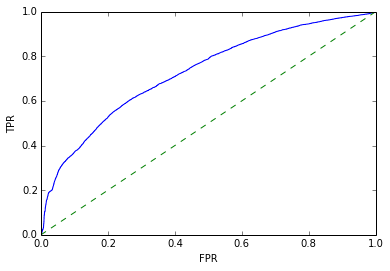

In [35]:
fpr, tpr, thresh = metrics.roc_curve(y_test, probs[:, 1])
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], 'g--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

## 5-fold Cross Validation

In [30]:
scores = cross_val_score(LogisticRegression(), X, y, scoring='roc_auc', cv=5)
print scores
print scores.mean()

[ 0.68570557  0.74171516  0.76213664  0.70860464  0.61783913]
0.703200226992


In [26]:
cv = KFold(n=len(X), n_folds=2)
print cv

sklearn.cross_validation.KFold(n=61340, n_folds=2, shuffle=False, random_state=None)


# Random Forrest

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
model3 = RandomForestClassifier(n_estimators = 80)
model3.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [41]:
# predict class labels for the test set
predicted = model3.predict(X_test)
probs = model3.predict_proba(X_test)
accuracy = metrics.accuracy_score(y_test, predicted)
auc = str(metrics.roc_auc_score(y_test, probs[:, 1]))
print 'Accuracy:', accuracy
print 'AUC:', auc

Accuracy: 0.973353925609
AUC: 0.842593207734


In [28]:
scores = cross_val_score(RandomForestClassifier(n_estimators = 80), X, y, scoring='roc_auc', cv=5)
print scores
print scores.mean()

[ 0.79097105  0.82232951  0.82877236  0.8017815   0.7117444 ]
0.791119765834


In [43]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,predicted)

array([[351871,   2091],
       [  7588,   1693]])

In [42]:
metrics.precision_score(y_test, predicted)

0.44741014799154333

Accuracy: 0.750190196718
AUC: 0.826044669444


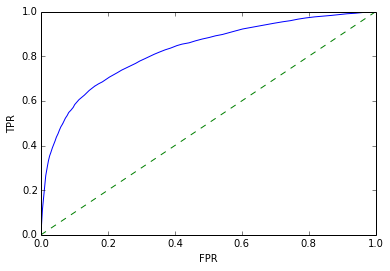

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
model2 = RandomForestClassifier(n_estimators = 80)
model2.fit(X_train, y_train)
# predict class labels for the test set
predicted = model2.predict(X_test)
probs = model2.predict_proba(X_test)
accuracy = metrics.accuracy_score(y_test, predicted)
auc = str(metrics.roc_auc_score(y_test, probs[:, 1]))
print 'Accuracy:', accuracy
print 'AUC:', auc
fpr, tpr, thresh = metrics.roc_curve(y_test, probs[:, 1])
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], 'g--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()